### This script reads coverage information for maltose metabolism genes in selected samples and plots a heatmap
#### author@aniafijarczyk

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

#### Reading files

In [2]:
# File with estimated coverage ratios in maltose metabolism genes in selected strains with good quality coverage
dm = pd.read_csv("./input_files/maltoseGenes_CNV.tab",sep="\t",header=0)
# File with metadata (Table S2) - replacing labels for the Jean-Talon
meta_file = pd.read_csv("./input_files/table_S2.csv",sep=",",header=0)[['Strain name','Type/style','Origin','Source']]
meta_noJT = meta_file.loc[meta_file['Strain name']!='Jean-Talon',:]
meta = meta_noJT.append(pd.DataFrame({'Strain name':['Jean-Talon'],'Type/style':['Jean-Talon'],
                                      'Origin':['Jean-Talon'],'Source':['Jean-Talon']})).reset_index().drop(columns=['index'])
# Merged data frame
df = pd.merge(dm, meta, left_on = ['strain'], right_on = ['Strain name'],how='left')
df.head()

,geneID,description,chrom,start,stop,type,Ratio,MedianRatio,CN,strain,Strain name,Type/style,Origin,Source
0,YBR297W,MAL33,ref|NC_001134|,800522,801929,gain,1.731935,1.491960,6.000000,A.1007,A.1007,Ale,Germany,Beer
1,YBR297W,MAL33,ref|NC_001134|,800522,801929,gain,1.530095,1.416452,5.666667,A.1728,A.1728,Ale,UK/IE,Beer
2,YBR297W,MAL33,ref|NC_001134|,800522,801929,gain,1.930788,2.148993,8.333333,A.2565,A.2565,Kolsch,Germany,Beer
3,YBR297W,MAL33,ref|NC_001134|,800522,801929,gain,1.773228,1.516825,4.666667,A.3942,A.3942,Wheat beer,Belgium,Beer
4,YBR297W,MAL33,ref|NC_001134|,800522,801929,.,1.151450,1.239850,2.000000,A.BRY-97,A.BRY-97,Ale,US/CA,Beer


#### Converting dataframe to matrix

In [3]:
matrix = pd.pivot_table(df,values='Ratio',index='strain',columns='description')
matrix.head()

description,IMA1,IMA2,IMA3,IMA4,IMA5,MAL11,MAL12,MAL13,MAL31,MAL32,MAL33,MPH2,MPH3
strain,,,,,,,,,,,,,
A.1007,2.508595,1.717175,1.460680,1.404874,0.656168,0.915078,2.172372,1.100189,4.002344,2.638321,1.731935,0.000000,0.000000
A.1728,1.664574,1.385067,1.076851,1.038608,0.691915,0.897085,1.548455,0.992680,2.743995,1.890870,1.530095,0.014129,0.019889
A.2565,2.925934,2.109690,1.666570,1.739745,0.682331,0.754721,2.486941,0.864784,4.211514,3.203683,1.930788,0.000613,0.002226
A.3942,2.795115,1.909847,1.433206,1.431923,0.820592,0.876390,1.831401,1.074003,3.498883,2.273310,1.773228,0.322992,0.352587
A.BRY-97,1.632927,0.562523,0.569626,0.651102,0.835312,0.887862,1.288202,1.071917,2.376381,1.616611,1.151450,0.022326,0.030838


#### Setting colors

In [4]:
# Colors for Type/style
dic_type = {'Bitter':'#D55E00',
 'Opaque':'white',
 'Ale':'lightskyblue',
 'Kolsch':'lightcoral',
 'Alt':'indianred',
 'Abbey':'white',
 'Strong ale':'lightskyblue',
 'Jean-Talon':'black',
 'Lager':'#0072B2',
 'Saison':'white',
 'Hefeweizen':'gold',
 'Pale ale':'#E69F00',
 'Wheat beer':'wheat',
 'Trappist':'#009E73',
 'Beer':'white',
 'Stout':'maroon',
 'Other':'white'}
df_type = pd.DataFrame({"Type/style":list(dic_type.keys()),"Type_color":list(dic_type.values())})
# Colors for geographic origin
dic_geo = {np.nan:'white',
 'Belgium':'#D55E00',
 'UK/IE':'#009E73',
 'Equador':'white',
 'Jean-Talon':'black',
 'Europe':'white',
 'US/CA':'#0072B2',
 'Germany':'#F0E442',
 'Other':'white',
 'Africa':'white',
 'Australia':'white'}
df_geo = pd.DataFrame({"Origin":list(dic_geo.keys()),"Origin_color":list(dic_geo.values())})
# Colors for source
dic_source = {"Beer":"#56B4E9",
             "Baking":"#E69F00",
             "Wild":"#009E73",
             "Clinical":"#F0E442",
             "Bio-ethanol":"wheat",
             "Jean-Talon":"black",
             "Lab":"#CC79A7",
             "Sake":"grey",
             "Spirits":"#0072B2",
             "Wine":"#D55E00"}
df_source = pd.DataFrame({"Source":list(dic_source.keys()),"Source_color":list(dic_source.values())})

#### Getting dendrograms

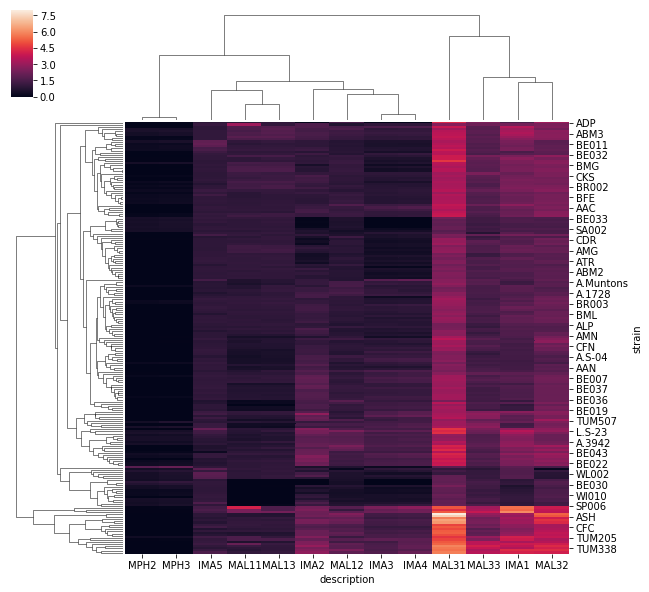

In [5]:
g = sns.clustermap(matrix)

#### Plotting heatmap

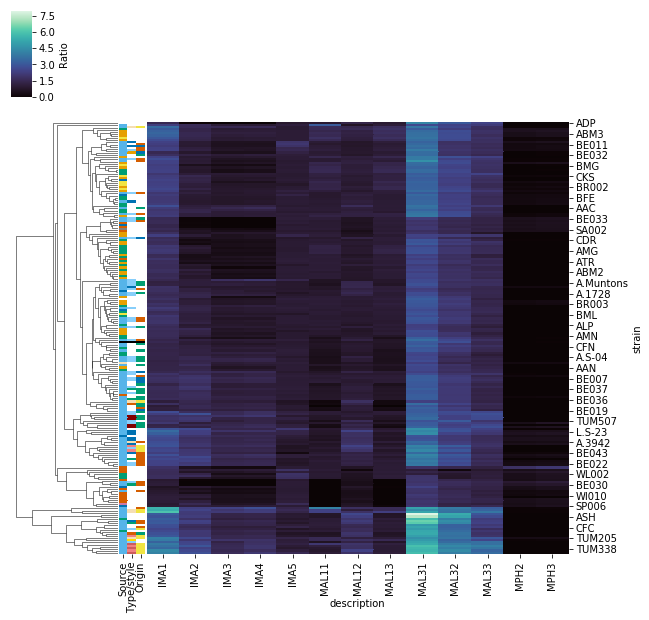

In [8]:
# Getting order of samples
strains = list(set(df["strain"]))
indices = g.dendrogram_row.reordered_ind
ds = pd.DataFrame({"strain":[strains[i] for i in indices]})
tab = pd.merge(ds, meta, left_on=["strain"],right_on=['Strain name'], how='left')

# Adding color code to ordered samples
tab2 = pd.merge(tab,df_source,on=['Source'],how='left')
tab3 = pd.merge(tab2,df_type,on=["Type/style"],how='left')
tab4 = pd.merge(tab3, df_geo, on=["Origin"],how='left')
tab5 = tab4.set_index(["strain"])[["Source_color","Type_color","Origin_color"]].rename(columns={"Source_color":"Source","Type_color":"Type/style","Origin_color":"Origin"})
tab5.head()

# Plotting heatmap
g = sns.clustermap(matrix, col_cluster=False, cmap="mako", row_colors=tab5, cbar_kws={"label":"Ratio"})

# Saving heatmap
g.savefig("./output/figure_heatmap_maltose.pdf",format="pdf")
#g.savefig("./output/figure_heatmap_maltose.png",format="png")